## We want to create a diversified Portfolio, model a hypothetical catastrophic event through a single day stock price drop of 10%(all stocks), and then compare it to the calculated 1-day VaR and CVaR. At the end we backtest by comparing to historical data for COVID crash

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

In [23]:
import yfinance as yf
import time
tickers = ['AAPL','MSFT', 'GOOG', 'NVDA', 'AMZN']

start_date = '2016-01-01'
end_date = '2019-12-01'

adj_close_data={}

for ticker in tickers:
    print(f"Downloading {ticker}...")
    t = yf.Ticker(ticker)
    df = t.history(start=start_date, end=end_date)
    adj_close_data[ticker] = df['Close']  # or 'Adj Close' if available
    time.sleep(0.5)  # optional delay just in case to prevent the server from being overloaded with requests

# Combine into dataframe
data = pd.DataFrame(adj_close_data)
print(data.head())

                                AAPL       MSFT       GOOG      NVDA  \
Date                                                                   
2016-01-04 00:00:00-05:00  23.803165  48.152298  36.872818  0.789676   
2016-01-05 00:00:00-05:00  23.206671  48.371975  36.909607  0.802362   
2016-01-06 00:00:00-05:00  22.752522  47.493282  36.961296  0.769184   
2016-01-07 00:00:00-05:00  21.792265  45.841328  36.104885  0.738690   
2016-01-08 00:00:00-05:00  21.907492  45.981922  35.512409  0.722833   

                                AMZN  
Date                                  
2016-01-04 00:00:00-05:00  31.849501  
2016-01-05 00:00:00-05:00  31.689501  
2016-01-06 00:00:00-05:00  31.632500  
2016-01-07 00:00:00-05:00  30.396999  
2016-01-08 00:00:00-05:00  30.352501  


In [24]:
returns=data.pct_change().dropna() #daily returns
weights = np.array([1/len(tickers)]*len(tickers)) #portfolio weights, here all weights equal
portfolio_returns=returns.dot(weights)
mean=portfolio_returns.mean()
std_dev=portfolio_returns.std()

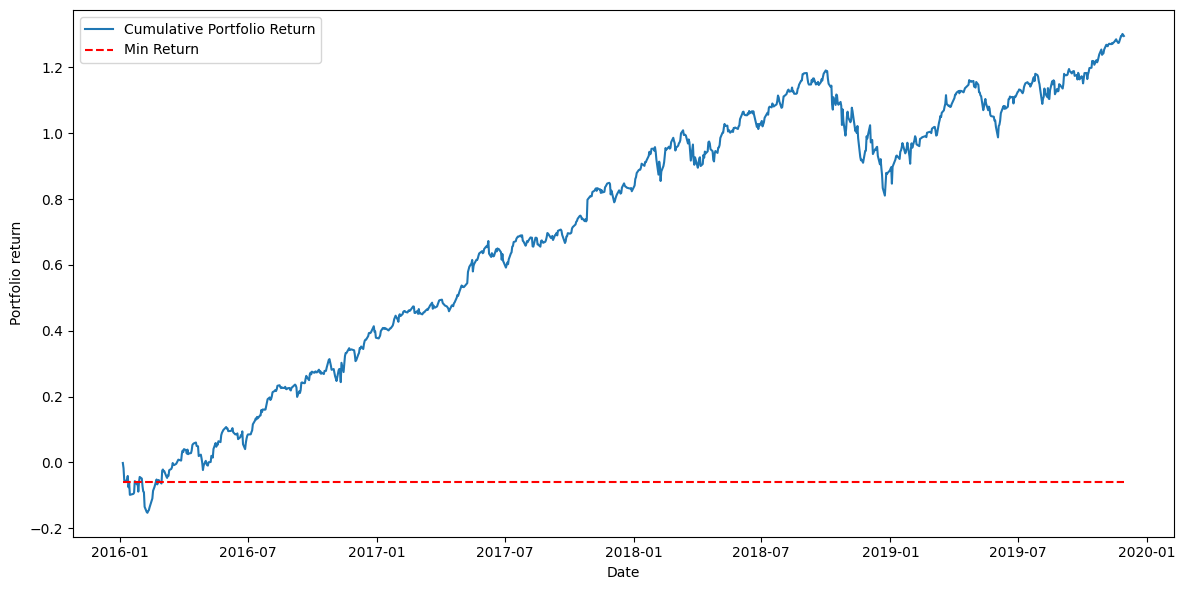

In [25]:
plt.figure(figsize=(12,6))
plt.plot(portfolio_returns.index, portfolio_returns.cumsum(), label='Cumulative Portfolio Return')
plt.hlines(y=portfolio_returns.min(), xmin=portfolio_returns.index.min(), xmax=portfolio_returns.index.max(), color='red', linestyle='--', label='Min Return')
plt.xlabel('Date')
plt.ylabel('Portfolio return')
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
from scipy.stats import t,norm
df, loc, scale = t.fit(portfolio_returns)
loc-mean, scale-std_dev

(np.float64(0.0007545916852703927), np.float64(-0.005251955811269379))

In [36]:
param_VaR = t.ppf(0.05, df, loc=loc, scale=scale)
CVaR=portfolio_returns[portfolio_returns <= param_VaR].mean()
print(f"1 day Value at Risk (VaR) at 95% confidence level: {param_VaR:.4f}")
print(f"1 day Conditional Value at Risk (CVaR) at 95% confidence level: {CVaR:.4f}")

1 day Value at Risk (VaR) at 95% confidence level: -0.0195
1 day Conditional Value at Risk (CVaR) at 95% confidence level: -0.0328


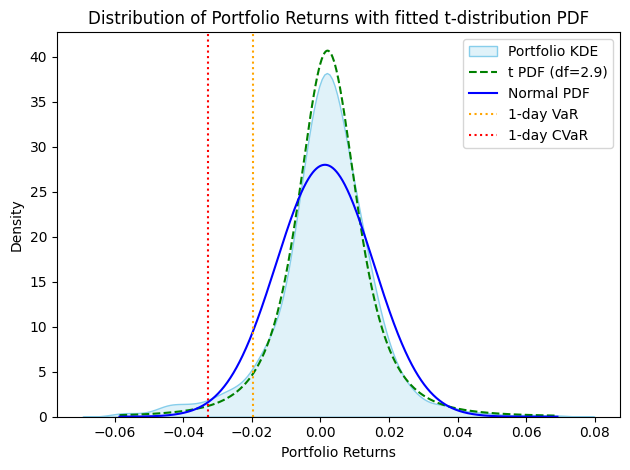

In [38]:
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)
sns.kdeplot(portfolio_returns, fill=True, color='skyblue', label='Portfolio KDE')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't PDF (df={df:.1f})')
plt.plot(x, norm.pdf(x, loc=mean, scale=std_dev), 'b-', label='Normal PDF')
plt.axvline(param_VaR, color='orange', linestyle=':', label='1-day VaR')
plt.axvline(CVaR, color='red', linestyle=':', label='1-day CVaR')

plt.title('Distribution of Portfolio Returns with fitted t-distribution PDF')
plt.xlabel('Portfolio Returns')
plt.legend()
plt.tight_layout()
plt.show()

### The t distribution models the peak and the tails much better than the normal

In [29]:
portfolio_returns.min()

np.float64(-0.0585586194787989)

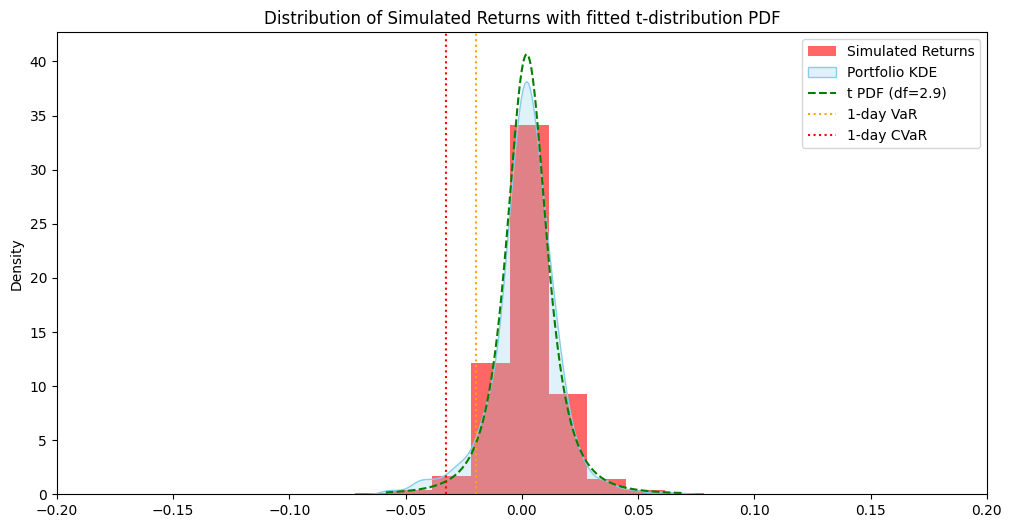

In [32]:
n_simulations = 100000
simulated_returns = loc + scale * np.random.standard_t(df, size=n_simulations)
plt.figure(figsize=(12,6))
plt.hist(simulated_returns, bins=100, density=True, alpha=0.6, color='r', label='Simulated Returns')
sns.kdeplot(portfolio_returns, fill=True, color='skyblue', label='Portfolio KDE')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't PDF (df={df:.1f})')
plt.xlim(-0.2, 0.2)
plt.axvline(param_VaR, color='orange', linestyle=':', label='1-day VaR')
plt.axvline(CVaR, color='red', linestyle=':', label='1-day CVaR')
plt.title('Distribution of Simulated Returns with fitted t-distribution PDF')
plt.legend()

In [41]:
confidence_level = 0.99
mc_var = np.percentile(simulated_returns, (1-confidence_level) * 100)
mc_cvar = simulated_returns[simulated_returns <= mc_var].mean()
print(f"Monte Carlo 1-day VaR at {confidence_level*100}% confidence level: {mc_var:.4f}")
print(f"Monte Carlo 1-day CVaR at {confidence_level*100}% confidence level: {mc_cvar:.4f}")

Monte Carlo 1-day VaR at 99.0% confidence level: -0.0411
Monte Carlo 1-day CVaR at 99.0% confidence level: -0.0673


In [42]:
t.cdf(-0.1,df, loc=loc, scale=scale)

np.float64(0.0009115407132155436)

In [44]:
np.percentile(simulated_returns, t.cdf(-0.1,df, loc=loc, scale=scale))

np.float64(-0.5105430686755713)

In [45]:
np.sum(simulated_returns>-0.1)/n_simulations  # Example of calculating the probability of returns being greater than -0.1

np.float64(0.99897)

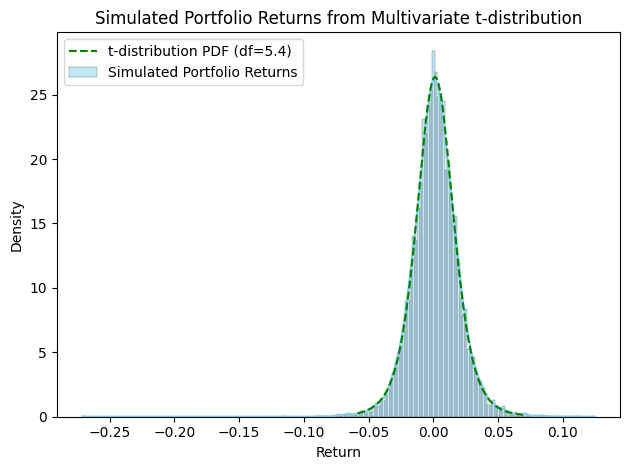

In [50]:
n_samples = 10000

  # degrees of freedom for the t-distribution
# mean vector and covariance matrix from your return data
mean_vec = returns.mean().values           # shape: (n_assets,)
cov_matrix = returns.cov().values          # shape: (n_assets, n_assets)
n_assets = len(mean_vec)
np.random.seed(42)  # for reproducibility
# === Step 2: Simulate from multivariate normal ===
z = np.random.multivariate_normal(mean=mean_vec, cov=cov_matrix, size=n_samples)  # shape: (n_samples, n_assets)

# === Step 3: Scale by sqrt of Gamma to get t-distribution ===
g = np.random.gamma(df / 2., 2. / df, size=n_samples)  # shape: (n_samples,)
scaling = np.sqrt(g)[:, None]  # reshape for broadcasting

# Simulate multivariate t
mvt_samples = mean_vec + (z - mean_vec) / scaling  # shape: (n_samples, n_assets)

portfolio_returns_mvt = mvt_samples.dot(weights)
df, loc, scale = t.fit(portfolio_returns_mvt)
sns.histplot(portfolio_returns_mvt, kde=True, stat='density', color='skyblue', label='Simulated Portfolio Returns')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't-distribution PDF (df={df:.1f})')
plt.title('Simulated Portfolio Returns from Multivariate t-distribution')
plt.xlabel('Return')    
plt.ylabel('Density')
plt.legend()    
plt.tight_layout()
plt.show()  

## The

=== Portfolio Risk Metrics with Multivariate t-distribution (99% confidence) ===
VaR_mvt: -0.0450
CVaR_mvt: -0.0598


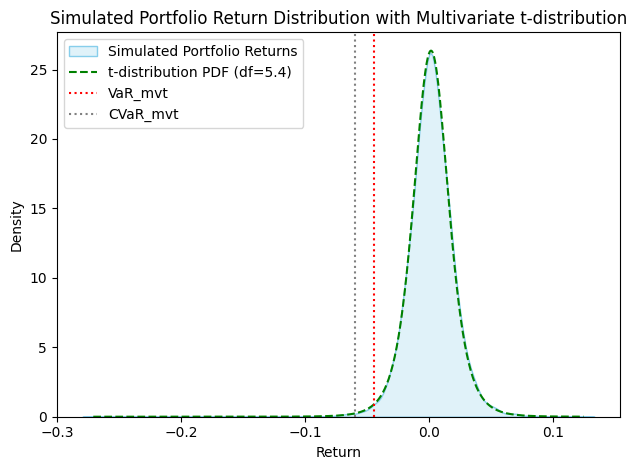

In [51]:
VaR_mvt = np.percentile(portfolio_returns_mvt, (1-confidence_level)*100)
CVaR_mvt = portfolio_returns_mvt[portfolio_returns_mvt <= VaR_mvt].mean()
print(f"=== Portfolio Risk Metrics with Multivariate t-distribution ({confidence_level*100:.0f}% confidence) ===")
print(f"VaR_mvt: {VaR_mvt:.4f}")            
print(f"CVaR_mvt: {CVaR_mvt:.4f}")
# Dashboard plot        
x = np.linspace(portfolio_returns_mvt.min(), portfolio_returns_mvt.max(), 1000)
sns.kdeplot(portfolio_returns_mvt, fill=True, color='skyblue', label='Simulated Portfolio Returns')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't-distribution PDF (df={df:.1f})')
plt.axvline(VaR_mvt, color='red', linestyle=':', label='VaR_mvt')
plt.axvline(CVaR_mvt, color='grey', linestyle=':', label='CVaR_mvt')
plt.title('Simulated Portfolio Return Distribution with Multivariate t-distribution')
plt.legend()
plt.xlabel('Return')
plt.ylabel('Density')
plt.tight_layout()
plt.show()